In [30]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import timm
from sklearn.preprocessing import label_binarize

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/aditya/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [32]:
import os

# Confirm subfolders inside path
print("Top-level:", os.listdir(path))

# Confirm what's inside the expected subfolder
inner_path = os.path.join(path, "The IQ-OTHNCCD lung cancer dataset")
print("Subfolders:", os.listdir(inner_path))


Top-level: ['Test cases', 'The IQ-OTHNCCD lung cancer dataset']
Subfolders: ['The IQ-OTHNCCD lung cancer dataset']


In [33]:
# 1. Load and preprocess the dataset
dataset_path = os.path.join(
    path,
    "The IQ-OTHNCCD lung cancer dataset",
    "The IQ-OTHNCCD lung cancer dataset"
)

categories = ["Bengin cases", "Malignant cases", "Normal cases"]

data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            data.append(img)
            labels.append(category)


In [34]:
# Convert data to numpy arrays and normalize
X = np.array(data) / 255.0  # Normalize pixel values to [0, 1]
print("Data shape:", X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
print("Classes:", label_encoder.classes_)
print("Encoded labels shape:", y.shape)

# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Data shape: (1097, 224, 224, 3)
Classes: ['Bengin cases' 'Malignant cases' 'Normal cases']
Encoded labels shape: (1097,)
Training set: (767, 224, 224, 3), Validation set: (165, 224, 224, 3), Test set: (165, 224, 224, 3)


In [37]:
# Import torchvision transforms for data augmentation
from torchvision import transforms
import torch.nn.functional as F

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for validation and test sets (no augmentation)
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class with transforms
class LungCancerDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets with appropriate transforms
train_dataset = LungCancerDataset(X_train, y_train, transform=train_transform)
val_dataset = LungCancerDataset(X_val, y_val, transform=val_transform)
test_dataset = LungCancerDataset(X_test, y_test, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [38]:
# Define CNN model
class LungCancerCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LungCancerCNN, self).__init__()

        # Convolutional layers with increased regularization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layers with increasing rates for deeper layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Convolutional blocks with dropout
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)  # 224x224 -> 112x112

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)  # 112x112 -> 56x56

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)  # 56x56 -> 28x28

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout4(x)  # 28x28 -> 14x14

        # Flatten
        x = x.view(-1, 256 * 14 * 14)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = LungCancerCNN().to(device)
print(model)


Using device: cpu
LungCancerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_fe

In [39]:
# Define loss function and optimizer with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Use CosineAnnealingLR for smoother learning rate adjustment
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,  # Restart every 10 epochs
    T_mult=1, 
    eta_min=1e-6
)


In [40]:
# Training function with early stopping and validation set
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update learning rate with cosine annealing
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Test phase (for monitoring only, not for model selection)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0

            # Save the best model
            torch.save(model.state_dict(), 'lung_cnn_state_dict.pth')
            torch.save(model, 'lung_cnn_full_model.pth')
            print(f"✓ New best model saved (Val Acc: {val_acc:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best epoch was {best_epoch+1} with Val Acc: {best_val_acc:.4f}")
            break

    print(f"Training completed. Best model from epoch {best_epoch+1} with Val Acc: {best_val_acc:.4f}")
    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, best_epoch

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total

    return loss, accuracy


In [41]:
# Train the model
num_epochs = 50  # Increased epochs with early stopping
patience = 10    # Early stopping patience

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies, best_epoch = train_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, 
    num_epochs=num_epochs, patience=patience
)


Epoch 1/50, LR: 0.000976, Train Loss: 15.7029, Train Acc: 0.4355, Val Loss: 3.4257, Val Acc: 0.5030, Test Loss: 3.5855, Test Acc: 0.5273
✓ New best model saved (Val Acc: 0.5030)
Epoch 2/50, LR: 0.000905, Train Loss: 2.0373, Train Acc: 0.5385, Val Loss: 0.9603, Val Acc: 0.5152, Test Loss: 0.9557, Test Acc: 0.5030
✓ New best model saved (Val Acc: 0.5152)
Epoch 3/50, LR: 0.000794, Train Loss: 0.9639, Train Acc: 0.5385, Val Loss: 0.8542, Val Acc: 0.7091, Test Loss: 0.8656, Test Acc: 0.7152
✓ New best model saved (Val Acc: 0.7091)
Epoch 4/50, LR: 0.000655, Train Loss: 0.9260, Train Acc: 0.5671, Val Loss: 0.8480, Val Acc: 0.6606, Test Loss: 0.8474, Test Acc: 0.6848
Epoch 5/50, LR: 0.000501, Train Loss: 0.9371, Train Acc: 0.5789, Val Loss: 0.8554, Val Acc: 0.6788, Test Loss: 0.8521, Test Acc: 0.6848
Epoch 6/50, LR: 0.000346, Train Loss: 0.8980, Train Acc: 0.5606, Val Loss: 0.8427, Val Acc: 0.6970, Test Loss: 0.8336, Test Acc: 0.6545
Epoch 7/50, LR: 0.000207, Train Loss: 0.8884, Train Acc: 0.5

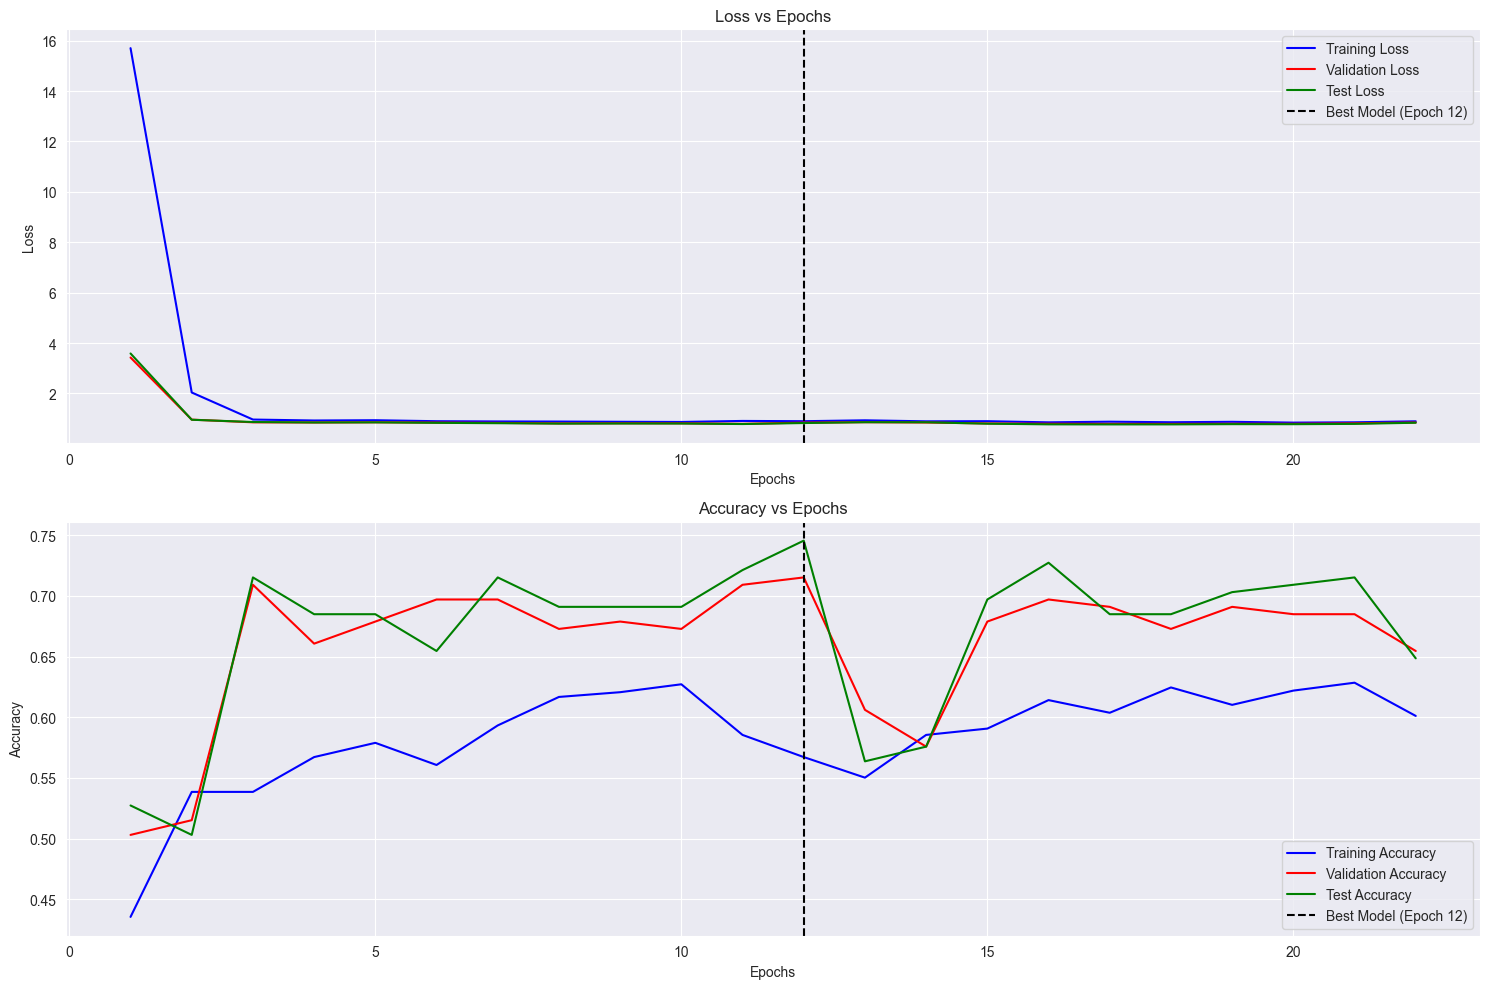

In [42]:
# Determine actual number of epochs trained
actual_epochs = len(train_losses)
epochs_range = range(1, actual_epochs+1)

# Plot loss vs epoch
plt.figure(figsize=(15, 10))

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
plt.plot(epochs_range, test_losses, 'g-', label='Test Loss')
plt.axvline(x=best_epoch+1, color='k', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
plt.plot(epochs_range, test_accuracies, 'g-', label='Test Accuracy')
plt.axvline(x=best_epoch+1, color='k', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


In [43]:
# Load the best model for evaluation
print("\n--- Evaluating Best Model on Test Set ---")
best_model = LungCancerCNN().to(device)
best_model.load_state_dict(torch.load('lung_cnn_state_dict.pth'))
best_model.eval()

# Evaluate the best model on the test set
test_loss, test_acc = evaluate_model(best_model, test_loader, criterion)
print(f"Best Model Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")



--- Evaluating Best Model on Test Set ---
Best Model Test Accuracy: 0.7455, Test Loss: 0.8258


In [44]:
# Get predictions for 100 test samples
def get_predictions(model, data_loader, num_samples=100):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_images = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_images.extend(inputs.cpu())

            if len(all_preds) >= num_samples:
                break

    return all_preds[:num_samples], all_labels[:num_samples], all_probs[:num_samples], all_images[:num_samples]

# Get predictions
print("\nGetting predictions for 100 test samples...")
predictions, true_labels, probabilities, images = get_predictions(best_model, test_loader, 100)



Getting predictions for 100 test samples...


In [46]:
# Convert numeric labels back to class names
class_names = label_encoder.classes_
pred_class_names = [class_names[pred] for pred in predictions]
true_class_names = [class_names[label] for label in true_labels]


In [47]:
# Create a DataFrame for visualization
results_df = pd.DataFrame({
    'True Label': true_class_names,
    'Predicted Label': pred_class_names,
    'Correct': [pred == true for pred, true in zip(predictions, true_labels)]
})

# Display the first few rows
print(results_df.head())

# Count of predictions by class
print("\nPrediction counts:")
print(results_df['Predicted Label'].value_counts())

# Count of true labels by class
print("\nTrue label counts:")
print(results_df['True Label'].value_counts())

# Overall accuracy
accuracy = results_df['Correct'].mean()
print(f"\nAccuracy on 100 samples: {accuracy:.4f}")


        True Label  Predicted Label  Correct
0  Malignant cases  Malignant cases     True
1  Malignant cases  Malignant cases     True
2     Normal cases     Normal cases     True
3     Normal cases     Normal cases     True
4  Malignant cases     Normal cases    False

Prediction counts:
Predicted Label
Malignant cases    60
Normal cases       40
Name: count, dtype: int64

True label counts:
True Label
Malignant cases    50
Normal cases       37
Bengin cases       13
Name: count, dtype: int64

Accuracy on 100 samples: 0.7500


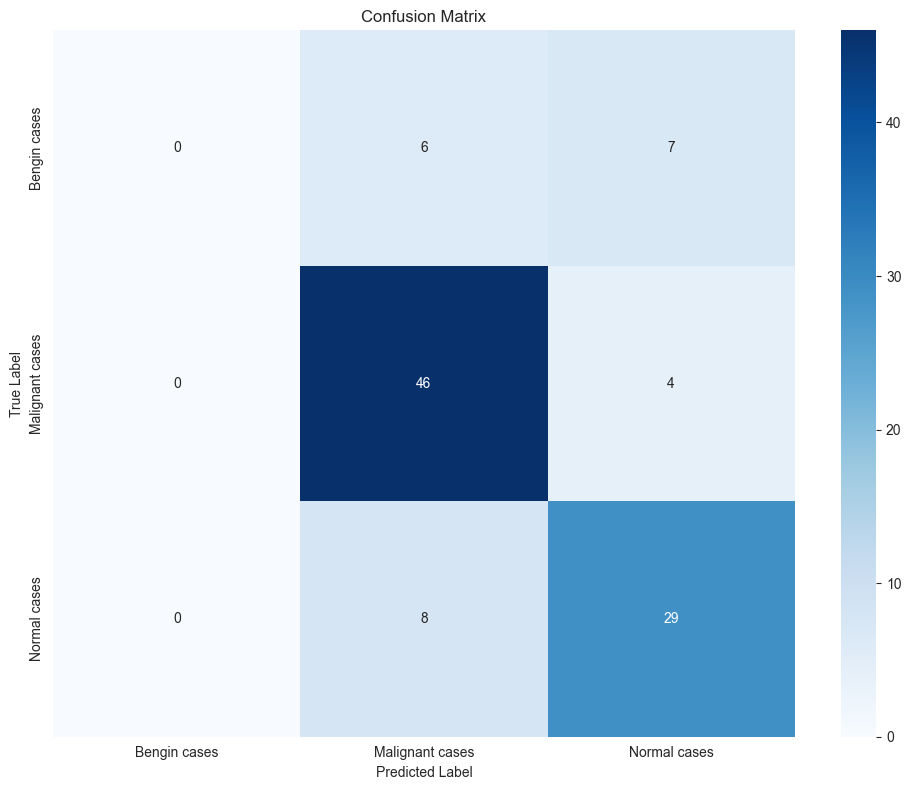

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()



Visualizing predictions...


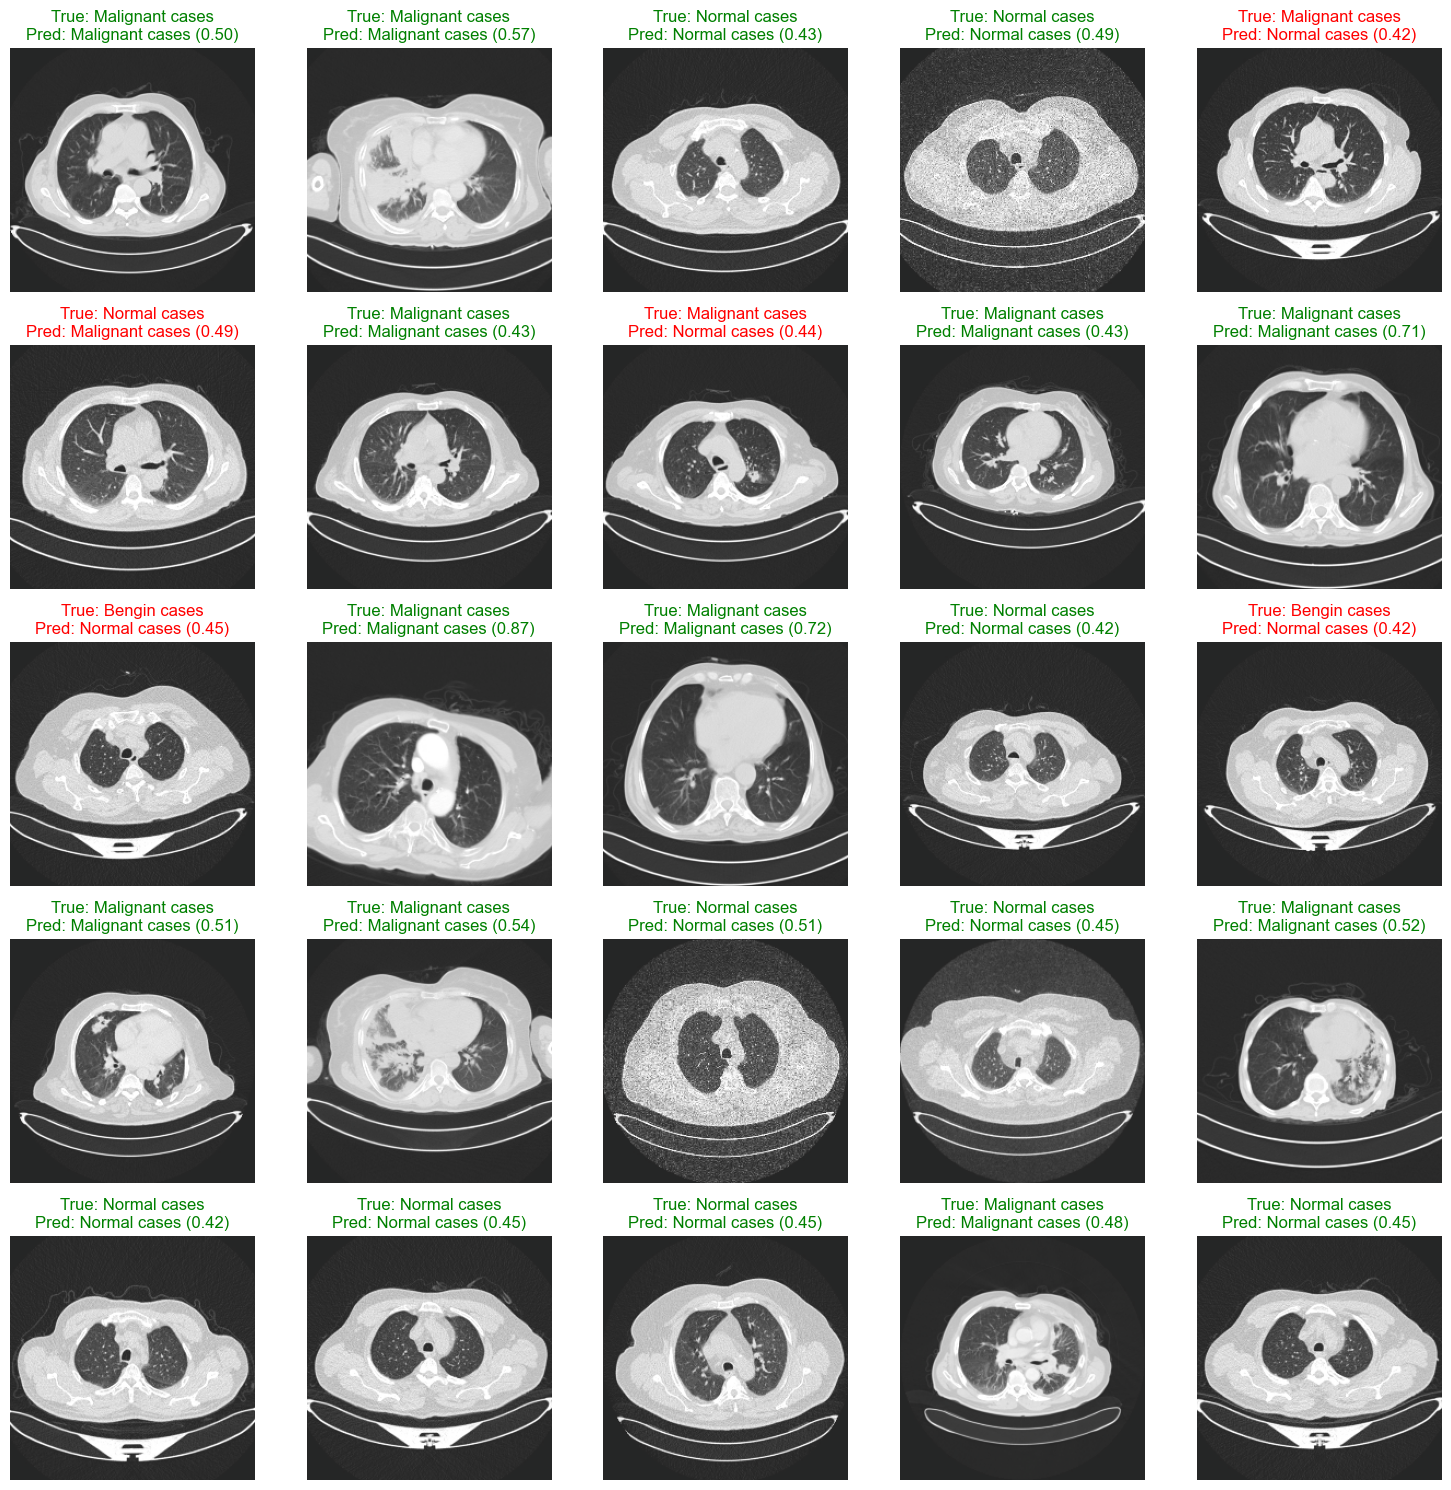

In [49]:
# Visualize some predictions
def plot_predictions(images, true_labels, predictions, class_names, probabilities=None, num_images=25):
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    # Denormalize images for better visualization
    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    for i in range(min(num_images, len(images))):
        # Denormalize and convert to numpy
        img = denorm(images[i]).permute(1, 2, 0).cpu().numpy()

        # Clip values to [0, 1] range
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)

        # Determine if prediction is correct
        is_correct = predictions[i] == true_labels[i]
        color = 'green' if is_correct else 'red'

        # Add confidence score if probabilities are provided
        if probabilities is not None:
            confidence = probabilities[i][predictions[i]]
            title = f"True: {class_names[true_labels[i]]}\nPred: {class_names[predictions[i]]} ({confidence:.2f})"
        else:
            title = f"True: {class_names[true_labels[i]]}\nPred: {class_names[predictions[i]]}"

        axes[i].set_title(title, color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Use the images and predictions we already got from get_predictions
print("\nVisualizing predictions...")
plot_predictions(
    images[:25], 
    true_labels[:25], 
    predictions[:25], 
    class_names, 
    probabilities=probabilities[:25] if probabilities else None
)


In [50]:
# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))



Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        13
Malignant cases       0.77      0.92      0.84        50
   Normal cases       0.72      0.78      0.75        37

       accuracy                           0.75       100
      macro avg       0.50      0.57      0.53       100
   weighted avg       0.65      0.75      0.70       100



/Users/aditya/PycharmProjects/Agent2/.venv3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aditya/PycharmProjects/Agent2/.venv3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aditya/PycharmProjects/Agent2/.venv3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

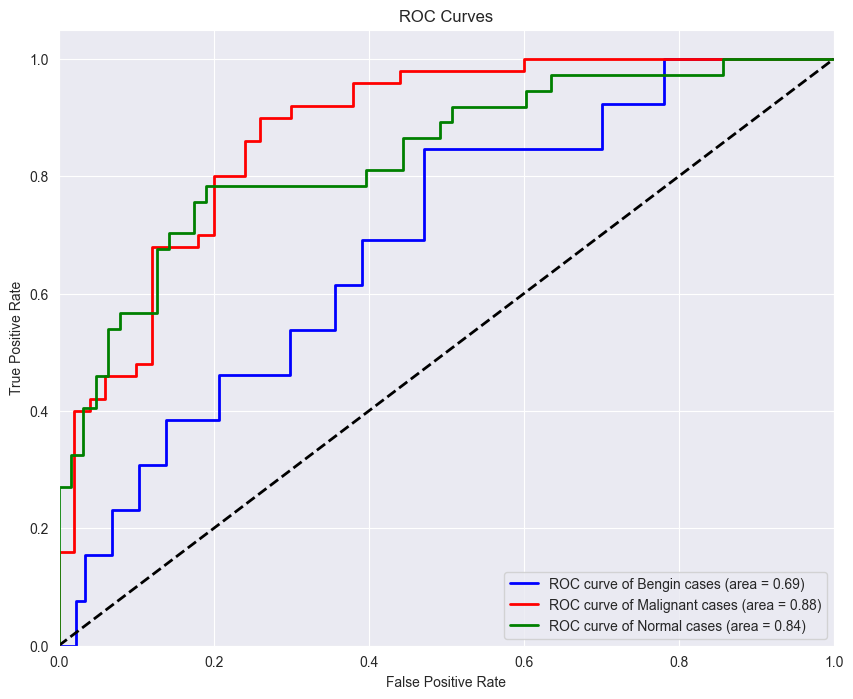

Training and evaluation completed successfully!


In [51]:
# ROC Curve and AUC (for multi-class)
y_test_bin = label_binarize(true_labels, classes=range(len(class_names)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], 
                                  [prob[i] for prob in probabilities])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i, color, cls in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {cls} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curves.png')
plt.show()

print("Training and evaluation completed successfully!")


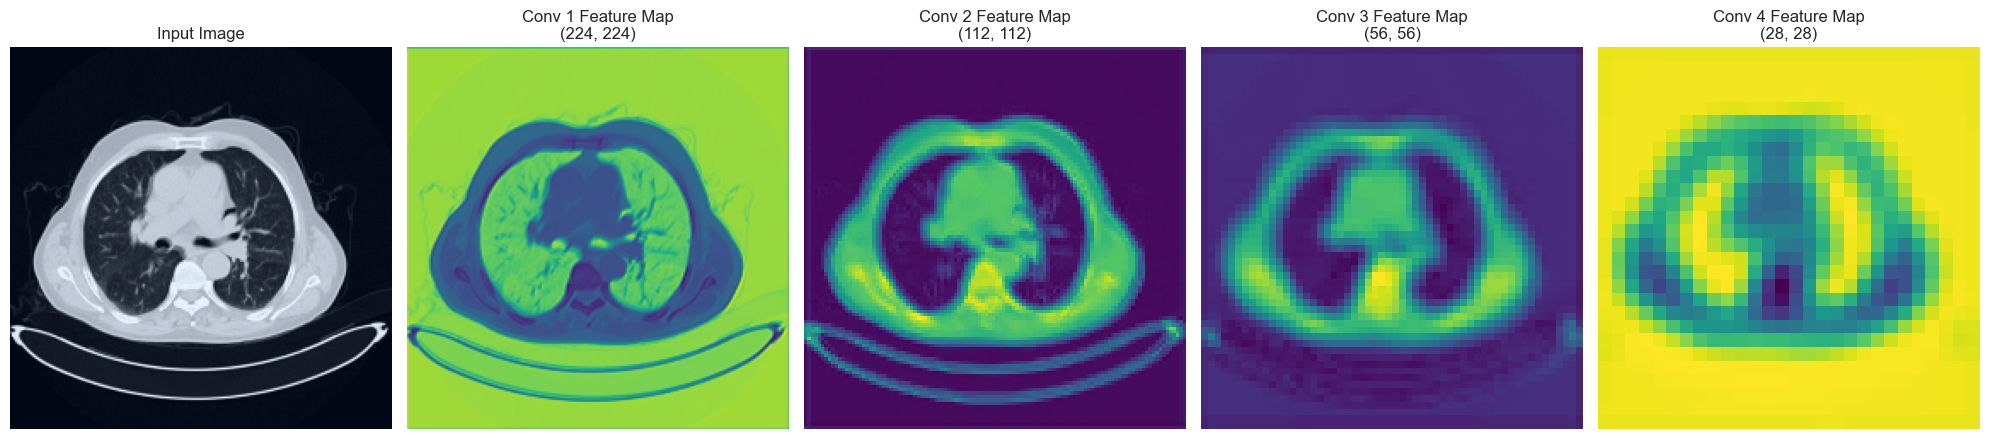

'model_architecture.png'

In [52]:
# Visualize the model architecture and feature maps
import torch.nn.functional as F
from torchviz import make_dot
import numpy as np
import matplotlib.pyplot as plt


def visualize_feature_maps(model, test_loader):
    # Get a batch of test images
    images, _ = next(iter(test_loader))
    image = images[0:1].to(device)  # Take first image

    # Dictionary to store feature maps
    feature_maps = {}

    # Hook function to capture feature maps
    def hook_fn(module, input, output):
        feature_maps[module] = output.detach()

    # Register hooks for convolutional layers
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot feature maps
    fig = plt.figure(figsize=(20, 10))

    # Plot input image
    plt.subplot(2, 5, 1)
    img = image[0].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')

    # Plot feature maps from each conv layer
    for idx, (layer, feat_map) in enumerate(feature_maps.items()):
        # Get first channel's feature map
        feat_map = feat_map[0, 0].cpu().numpy()

        plt.subplot(2, 5, idx + 2)
        plt.imshow(feat_map, cmap='viridis')
        plt.title(f'Conv {idx + 1} Feature Map\n{feat_map.shape}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('cnn_visualization.png')
    plt.show()


# Load best model and visualize
best_model = LungCancerCNN().to(device)
best_model.load_state_dict(torch.load('lung_cnn_state_dict.pth'))
best_model.eval()

visualize_feature_maps(best_model, test_loader)

# Create model graph visualization
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = best_model(sample_input)
dot = make_dot(output, params=dict(best_model.named_parameters()))
dot.render("model_architecture", format="png")